# Introduction

Before applying any fancy algorithms, the next step is to simply explore whether the processed corpuses and DTMs make sense.

When working with numerical data, some EDA techniques we can use include finding the mean, median or mode as well as the distribution of a data set. 

For text, we are going to find some more **obvious** patterns with EDA before identifying the hidden patterns with machines learning (ML) techniques. Relatively obious things are:

1. **Most common words** - find these and create word clouds
2. **Size of vocabulary** - look number of unique words

## Outline for EDA
1. With the DTM from the previous stage, sort into columns according to ascending order in value (of occurence)
2. Aggregate (or filter) data - select columns with the largest values.
3. Visualise top words - word clouds? bar charts?
4. Insights - a written comment/ description of the key takeaways.
5. Probably also try using TF-IDF (Term frequency - inverse data frequency) for better understanding the "uniqueness" or the "value" of the the vocabulary in the text.

# Most Common Words

Using the refined database from the previous data cleaning stage, we can now extract the most common words from all of the texts in the corpus. 

In [1]:
import pandas as pd
pd.set_option('max_colwidth',150)
import pickle

# database indexes, headers 
bookNames = ['chocofact','fox','matilda']
fullNames = ['Charlie and the Chocolate Factory','Fantastic Mr Fox!','Matilda']

data = pd.read_pickle("refined_dtm.pkl")
data

,say,not,mr,miss,matilda,honey,go,wonka,like,come,...,wage,broad,waft,satchel,victory,view,oyster,practically,authority,tingle
book_names,,,,,,,,,,,,,,,,,,,,,
chocofact,352,258,386,12,0,0,159,297,103,137,...,1,0,1,0,1,1,2,1,0,1
fox,152,66,132,2,0,0,39,0,23,32,...,0,0,1,0,0,0,0,0,0,0
matilda,589,336,70,453,405,369,155,0,163,114,...,1,2,0,2,1,1,0,1,2,1
sum,1093,660,588,467,405,369,353,297,289,283,...,2,2,2,2,2,2,2,2,2,2


We take note that there are currently 2394 words within the dataframe.

We are now going to tranpose it to reveal the top 10 words on the entire list. (Note that the data is already been sorted previously, so all I have to do is to mask out the remaining entries.) 

In [2]:
data = data.transpose()
data.head(20)

book_names,chocofact,fox,matilda,sum
say,352,152,589,1093
not,258,66,336,660
mr,386,132,70,588
miss,12,2,453,467
matilda,0,0,405,405
honey,0,0,369,369
go,159,39,155,353
wonka,297,0,0,297
like,103,23,163,289
come,137,32,114,283


This is pretty unremarkable considering that words such as "say", "mr", "miss" etc. should be considered stop words. To mitigate this, I am going to remove words that have appeared more than 20 times in each of the 2 or more texts.

In [3]:
filtered_data = data
filtered_data = data[((data.chocofact <= 20) &  (data.fox <= 20)) | ((data.chocofact <= 20) &  (data.matilda <= 20)) | ((data.matilda <= 20) &  (data.fox <= 20))]

# Pickle this 
filtered_data.to_pickle("gross_top_dict.pkl")
filtered_data

book_names,chocofact,fox,matilda,sum
miss,12,2,453,467
matilda,0,0,405,405
honey,0,0,369,369
wonka,297,0,0,297
charlie,241,0,0,241
...,...,...,...,...
view,1,0,1,2
oyster,2,0,0,2
practically,1,0,1,2
authority,0,0,2,2


Conversely, we can apply the opposite conditions to see what are the words that were removed in the process.

In [4]:
removed_data = data
removed_data = data[((data.chocofact > 20) &  (data.fox > 20)) | ((data.chocofact > 20) &  (data.matilda > 20)) | ((data.matilda > 20) &  (data.fox > 20))]
removed_data

book_names,chocofact,fox,matilda,sum
say,352,152,589,1093
not,258,66,336,660
mr,386,132,70,588
go,159,39,155,353
like,103,23,163,289
...,...,...,...,...
give,22,8,25,55
ill,26,6,23,55
moment,21,8,25,54
far,23,5,24,52


Let's print all the removed words neatly and add them to a list.

In [5]:
# Return the list of removed words
filtered_removed_data = removed_data.transpose()
filtered_removed_data = filtered_removed_data.drop(bookNames)
filtered_removed_data

,say,not,mr,go,like,come,look,mrs,little,cry,...,inside,open,tiny,home,stare,give,ill,moment,far,large
book_names,,,,,,,,,,,,,,,,,,,,,
sum,1093,660,588,353,289,283,258,220,215,208,...,65,63,63,61,59,55,55,54,52,48


In [6]:
removed_list = filtered_removed_data.keys().to_list()
print(', '.join([word for word in removed_list]))

say, not, mr, go, like, come, look, mrs, little, cry, know, right, child, have, think, get, time, shout, ask, small, room, father, thing, tell, day, boy, stand, want, good, hand, long, sit, great, old, be, head, will, away, house, mother, take, eye, door, begin, see, turn, find, way, stop, oh, eat, start, suddenly, face, leave, yes, glass, round, hear, girl, man, happen, watch, place, mean, end, try, bit, course, hold, inside, open, tiny, home, stare, give, ill, moment, far, large


Luckily, the number of entries for `filtered_data` and `removed_data` does add up to 2394. We can now use this to plot a wordcloud for the 30 most common words within all the texts of the corpus.

To use the dataframe for the wordcloud, we have to work on several things:
1. Only keep the list of sum (remove columns corresponding individual texts)
2. Obtain the list of top 30 words, which means the dataframe must be transposed such that the keys can be accessed; and,
3. Obtain the list of sums
4. Using the 2 lists obtained in the 2 previous steps create pairs, which can be parsed into the word cloud generator.

In [7]:
wordcloud_dtm = filtered_data
wordcloud_dtm = wordcloud_dtm.drop(bookNames, axis=1)
wordcloud_dtm

book_names,sum
miss,467
matilda,405
honey,369
wonka,297
charlie,241
...,...
view,2
oyster,2
practically,2
authority,2


In [8]:
# Obtain the frequencies
cloud_freq = wordcloud_dtm['sum'].to_list()
cloud_freq

[467,
 405,
 369,
 297,
 241,
 233,
 198,
 159,
 144,
 123,
 91,
 85,
 83,
 82,
 80,
 80,
 79,
 79,
 73,
 68,
 67,
 66,
 65,
 64,
 64,
 64,
 63,
 62,
 62,
 61,
 60,
 60,
 59,
 59,
 58,
 57,
 56,
 55,
 55,
 54,
 53,
 52,
 52,
 52,
 52,
 52,
 52,
 51,
 50,
 50,
 50,
 49,
 49,
 48,
 48,
 48,
 48,
 47,
 47,
 47,
 46,
 46,
 45,
 45,
 45,
 44,
 44,
 44,
 44,
 44,
 44,
 43,
 43,
 43,
 42,
 42,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 40,
 40,
 40,
 40,
 40,
 40,
 39,
 39,
 38,
 38,
 38,
 38,
 38,
 38,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 36,
 36,
 36,
 36,
 35,
 35,
 35,
 35,
 35,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 33,
 33,
 33,
 33,
 33,
 32,
 32,
 32,
 32,
 31,
 31,
 31,
 31,
 31,
 31,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 29,
 29,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 24,
 24,


In [9]:
# Obtain the list of words to be inserted into the word cloud.
wordcloud_dtm = wordcloud_dtm.transpose()
cloud_list = wordcloud_dtm.keys().to_list()
cloud_list

['miss',
 'matilda',
 'honey',
 'wonka',
 'charlie',
 'fox',
 'trunchbull',
 'grandpa',
 'chocolate',
 'joe',
 'teavee',
 'wormwood',
 'read',
 'let',
 'bean',
 'factory',
 'school',
 'bucket',
 'ticket',
 'lift',
 'book',
 'dear',
 'badger',
 'table',
 'oompa',
 'people',
 'golden',
 'feel',
 'run',
 'gloop',
 'loompa',
 'big',
 'call',
 'year',
 'soon',
 'lavender',
 'gum',
 'second',
 'class',
 'bar',
 'salt',
 'world',
 'hair',
 'hole',
 'chew',
 'wait',
 'shall',
 'headmistress',
 'bunce',
 'talk',
 'water',
 'walk',
 'live',
 'slowly',
 'television',
 'mike',
 'bed',
 'fast',
 'keep',
 'parent',
 'answer',
 'work',
 'floor',
 'piece',
 'scream',
 'augustus',
 'violet',
 'yell',
 'woman',
 'morning',
 'car',
 'sure',
 'foot',
 'air',
 'half',
 'tunnel',
 'love',
 'beauregarde',
 'close',
 'grow',
 'well',
 'wall',
 'push',
 'veruca',
 'grandma',
 'smile',
 'whisper',
 'life',
 'dig',
 'carefully',
 'make',
 'stick',
 'listen',
 'minute',
 'mouth',
 'lot',
 'high',
 'teacher',
 'bu

In [10]:
pairs = []
for i in range(0,len(cloud_list)):
    pairs.append((cloud_list[i], int(cloud_freq[i])))

pairs

[('miss', 467),
 ('matilda', 405),
 ('honey', 369),
 ('wonka', 297),
 ('charlie', 241),
 ('fox', 233),
 ('trunchbull', 198),
 ('grandpa', 159),
 ('chocolate', 144),
 ('joe', 123),
 ('teavee', 91),
 ('wormwood', 85),
 ('read', 83),
 ('let', 82),
 ('bean', 80),
 ('factory', 80),
 ('school', 79),
 ('bucket', 79),
 ('ticket', 73),
 ('lift', 68),
 ('book', 67),
 ('dear', 66),
 ('badger', 65),
 ('table', 64),
 ('oompa', 64),
 ('people', 64),
 ('golden', 63),
 ('feel', 62),
 ('run', 62),
 ('gloop', 61),
 ('loompa', 60),
 ('big', 60),
 ('call', 59),
 ('year', 59),
 ('soon', 58),
 ('lavender', 57),
 ('gum', 56),
 ('second', 55),
 ('class', 55),
 ('bar', 54),
 ('salt', 53),
 ('world', 52),
 ('hair', 52),
 ('hole', 52),
 ('chew', 52),
 ('wait', 52),
 ('shall', 52),
 ('headmistress', 51),
 ('bunce', 50),
 ('talk', 50),
 ('water', 50),
 ('walk', 49),
 ('live', 49),
 ('slowly', 48),
 ('television', 48),
 ('mike', 48),
 ('bed', 48),
 ('fast', 47),
 ('keep', 47),
 ('parent', 47),
 ('answer', 46),
 ('w

In [11]:
pairs_dict = dict((x, y) for x, y in pairs)
pairs_dict

{'miss': 467,
 'matilda': 405,
 'honey': 369,
 'wonka': 297,
 'charlie': 241,
 'fox': 233,
 'trunchbull': 198,
 'grandpa': 159,
 'chocolate': 144,
 'joe': 123,
 'teavee': 91,
 'wormwood': 85,
 'read': 83,
 'let': 82,
 'bean': 80,
 'factory': 80,
 'school': 79,
 'bucket': 79,
 'ticket': 73,
 'lift': 68,
 'book': 67,
 'dear': 66,
 'badger': 65,
 'table': 64,
 'oompa': 64,
 'people': 64,
 'golden': 63,
 'feel': 62,
 'run': 62,
 'gloop': 61,
 'loompa': 60,
 'big': 60,
 'call': 59,
 'year': 59,
 'soon': 58,
 'lavender': 57,
 'gum': 56,
 'second': 55,
 'class': 55,
 'bar': 54,
 'salt': 53,
 'world': 52,
 'hair': 52,
 'hole': 52,
 'chew': 52,
 'wait': 52,
 'shall': 52,
 'headmistress': 51,
 'bunce': 50,
 'talk': 50,
 'water': 50,
 'walk': 49,
 'live': 49,
 'slowly': 48,
 'television': 48,
 'mike': 48,
 'bed': 48,
 'fast': 47,
 'keep': 47,
 'parent': 47,
 'answer': 46,
 'work': 46,
 'floor': 45,
 'piece': 45,
 'scream': 45,
 'augustus': 44,
 'violet': 44,
 'yell': 44,
 'woman': 44,
 'morning':

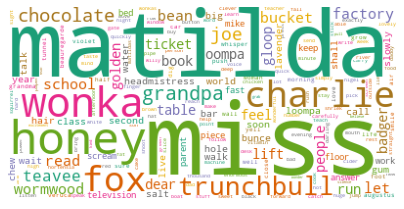

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = [7, 5]

# image_mask = np.array(Image.open('fox.png'))
wc = WordCloud(background_color="white", colormap="Dark2", random_state=42) # mask = image_mask)

wc.fit_words(pairs_dict)
plt.imshow(wc)
plt.axis("off")
plt.show()

## Word Clouds for individual texts
However, as we can see, since the themes covered within the texts are quite dynamic, the word cloud can't really point to a specific theme. A better idea would be to create individual word cloud for each text. Hence, the entire process is repeated for each text. To begin, we start with the `filtered_data` dataframe that we have created earlier:

In [13]:
full_filtered_data = filtered_data.drop("sum", axis=1)
full_filtered_data

book_names,chocofact,fox,matilda
miss,12,2,453
matilda,0,0,405
honey,0,0,369
wonka,297,0,0
charlie,241,0,0
...,...,...,...
view,1,0,1
oyster,2,0,0
practically,1,0,1
authority,0,0,2


In [14]:
# Find the top words in each text, and return as a list of list of pairs.
top_dict = {}
for c in full_filtered_data.columns:
    top = full_filtered_data[c].sort_values(ascending=False) # want to be descending (large to small), so not ascending.
    top_dict[c]= list(zip(top.index, top.values))

top_dict

),
  ('sick', 0),
  ('immediately', 0),
  ('burp', 0),
  ('hardly', 0),
  ('slightly', 0),
  ('month', 0),
  ('gigantic', 0),
  ('grandma', 0),
  ('famous', 0),
  ('single', 0),
  ('cow', 0),
  ('glue', 0),
  ('story', 0),
  ('splendid', 0),
  ('cigar', 0),
  ('busy', 0),
  ('complete', 0),
  ('angry', 0),
  ('blueberry', 0),
  ('own', 0),
  ('veruca', 0),
  ('writing', 0),
  ('university', 0),
  ('beauregarde', 0),
  ('forget', 0),
  ('parent', 0),
  ('quality', 0),
  ('early', 0),
  ('squirm', 0),
  ('some', 0),
  ('gaze', 0),
  ('knock', 0),
  ('clothe', 0),
  ('square', 0),
  ('address', 0),
  ('wise', 0),
  ('silent', 0),
  ('tub', 0),
  ('journey', 0),
  ('bye', 0),
  ('pupil', 0),
  ('saucepan', 0),
  ('car', 0),
  ('top', 0),
  ('limerick', 0),
  ('phut', 0),
  ('newspaper', 0),
  ('violet', 0),
  ('slip', 0),
  ('teacher', 0),
  ('belt', 0),
  ('tremble', 0),
  ('michael', 0),
  ('visitor', 0),
  ('advance', 0),
  ('superglue', 0),
  ('spy', 0),
  ('dye', 0),
  ('baby', 0),
  

In [15]:
# Print the 30 words neatly.

for text, top_words in top_dict.items():
    print(text, ":")
    print(', '.join([word for word, count in top_words[0:29]]))
    print('---')

chocofact :
wonka, charlie, grandpa, chocolate, joe, teavee, factory, bucket, ticket, oompa, gloop, loompa, golden, salt, gum, bar, chew, lift, mike, people, dear, augustus, television, violet, beauregarde, veruca, grandma, bed, river
---
fox :
fox, badger, bean, bunce, hole, dig, tunnel, chicken, cider, boggi, jar, dad, let, wait, boggis, rat, night, soon, food, run, hill, shall, farm, duck, big, wall, dear, feast, darling
---
matilda :
miss, matilda, honey, trunchbull, wormwood, school, read, book, lavender, class, table, headmistress, let, feel, car, year, hair, call, water, teacher, talk, walk, cake, hortensia, second, keep, nigel, parent, teach
---


As far as concerned, we don't really see any top words that exist in multiple texts, which means that the stop words removal during the data cleaning stage worked quite well indeed! 

Let's pickle this and generate the word clouds.

In [16]:
with open("dahl_top_dict.pkl", "wb") as file:
    pickle.dump(top_dict, file)

In [17]:
# Test obtaining a dictionary from a story.
fox_pairs = top_dict["fox"]
pairs_dict = dict((x, y) for x, y in fox_pairs)
pairs_dict

{'fox': 233,
 'badger': 65,
 'bean': 64,
 'bunce': 50,
 'hole': 42,
 'dig': 38,
 'tunnel': 32,
 'chicken': 28,
 'cider': 26,
 'boggi': 23,
 'jar': 21,
 'dad': 21,
 'let': 18,
 'wait': 18,
 'boggis': 17,
 'rat': 17,
 'night': 16,
 'soon': 16,
 'food': 15,
 'run': 15,
 'hill': 14,
 'shall': 13,
 'farm': 13,
 'duck': 13,
 'big': 12,
 'wall': 12,
 'dear': 12,
 'feast': 12,
 'darling': 12,
 'farmer': 12,
 'foxs': 12,
 'gun': 12,
 'fat': 12,
 'shovel': 12,
 'huge': 11,
 'rabbit': 10,
 'tail': 10,
 'close': 10,
 'machine': 9,
 'quickly': 9,
 'hungry': 9,
 'keep': 9,
 'woman': 9,
 'tree': 9,
 'shelf': 9,
 'cellar': 9,
 'wood': 9,
 'sight': 9,
 'brick': 8,
 'fast': 8,
 'drink': 8,
 'weasel': 8,
 'stay': 8,
 'smile': 8,
 'earth': 8,
 'geese': 8,
 'smell': 8,
 'foot': 8,
 'bang': 8,
 'quick': 8,
 'shriek': 7,
 'mole': 7,
 'floor': 7,
 'excitement': 7,
 'push': 7,
 'forward': 7,
 'slowly': 7,
 'crouch': 7,
 'idea': 7,
 'turkey': 7,
 'foxy': 7,
 'starve': 7,
 'lovely': 7,
 'step': 7,
 'black': 7,
 

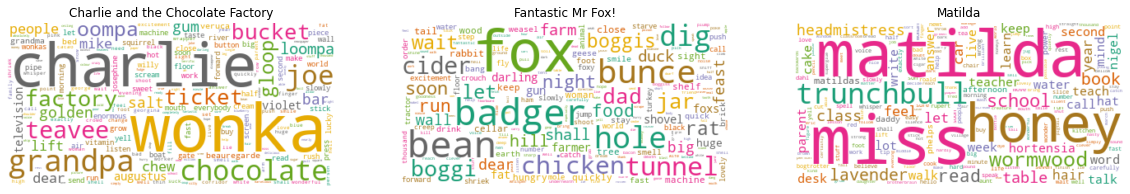

In [18]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [20, 20]

fullNames = [
    'Charlie and the Chocolate Factory',
    'Fantastic Mr Fox!',
    'Matilda'
]

# Create subplots for each comedian
for index, storyName in enumerate(full_filtered_data.columns):

    dahl_pairs = top_dict[storyName]
    pairs_dict = dict((x, y) for x, y in dahl_pairs)

    wc.fit_words(pairs_dict)
    
    plt.subplot(2, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(fullNames[index])
    
plt.show()

## Brief findings for word clouds

1. Charlie and the Chocolate factory: Dahl describes a lot about Charlie (Bucket) and (Willy) Wonka in the story. This is unsurprising considering that they are the main characters of the text. As expected, we also identify other key characters such as Oompa-Loompas, Mike Teavee, Augustus Gloop, Veruca Salt, Violet Bearegarde and Grandpa Joe. Likewise, we see objects such as the golden ticket, chocolate bars (and perhaps the chocolate river!) that are omnipresent throughout the story. In my memory, the lift was never a big part of the story, but I guess its something frequently referred to by Mr Wonka, especially towards the end of the story which guides readers to the sequel "Charlie and the Great Glass Elevator".

2. Fantastic Mr Fox: Here we see the key characters (Mr) Fox, his friend Badger, and  the three wicked farmers Boggis, Bunce and Bean. Diggging tunnels were a big part of the story considering that they were fleeing from the ill-willed farmers. Another thing to note is that things at the end of the story, such as feast, cider (and the Rat?), were caught in the word cloud; I presume this is due to the relatively short length of the story.

3. Matilda: Despite the happy ending of the story, for the most part I do find it very distrubing, whether it be the cruel and dim-witted descriptions of (most) adults or the "telekenetic" powers that Matilda possesed (for the most part of the story). Similar to other stories, we identify characters such as Matilda Wormwood, her friend Lavender, Miss Honey, and the headmistress Miss Treachbull.

4. Overall: Unfortunately this word cloud is almost identical to the Matilda word cloud, which is likely due to Matilda being an inherently lengthier story. One way to mitigate this problem would be to account fo the actual length of each story and to weigh the frequencies of the words accordingly. This may be something we will deal with after obtaining more statistics later in this project.

To sum up, we mainly see Dahl's silly characters' names in the word clouds, which are, to be fair, a large part of his fairy-like stories directed towards children. However, as a result of tokenizing the text, we cannot directly identify things like his (somewhat dark) humour and sacarsm, personification, overly descriptive writing style, and most importantly, his portrayal of a world where (most/ all) adults are villains, and where kids have the power to do whatever they so desire.

# Unique Words

## Total Word Count
To obtain the total word count, we simply import `basic_cleaned_corpus.pkl` and find the number of words in each text.

In [19]:
t_count_dtm = pd.read_pickle("basic_cleaned_corpus.pkl")
t_count_dtm

,text
book_names,
chocofact,here comes charlie these two very old people are the father and mother of mr bucket their names are grandpa joe and grandma josephine a...
fox,down in the valley there were three farms the owners of these farms had done well they were rich men they were also nasty men all three of the...
matilda,the reader of books its a funny thing about mothers and fathers even when their own child is the most disgusting little blister you could e...


In [20]:
import string

# Find the total number of words that a comedian uses
total_list = []
for storyName in bookNames:
    count = len(t_count_dtm.text.loc[storyName].split())
    total_list.append(count)

# Present it nicely!
total_count_dtm = pd.DataFrame({'book_names':bookNames, 'full_names': fullNames, 'total_count': total_list})
total_count_dtm

,book_names,full_names,total_count
0,chocofact,Charlie and the Chocolate Factory,31291
1,fox,Fantastic Mr Fox!,9527
2,matilda,Matilda,40394


## Unique Word Count

Now that we have the total word count, we can find the number of unique words. For consistency, I am going to use  `filtered_data`, which excludes stop words.

In [21]:
filtered_data

book_names,chocofact,fox,matilda,sum
miss,12,2,453,467
matilda,0,0,405,405
honey,0,0,369,369
wonka,297,0,0,297
charlie,241,0,0,241
...,...,...,...,...
view,1,0,1,2
oyster,2,0,0,2
practically,1,0,1,2
authority,0,0,2,2


In [22]:
# Find the total number of unique words in each text
unique_count_list = []
for story in data.columns:
    count = sum(data[story])
    unique_count_list.append(count)
    
unique_count_list

[13906, 4170, 16348, 34424]

In [23]:
unique_count_list.pop() # pop the sum
unique_count_dtm = pd.DataFrame({'book_names':bookNames, 'full_names': fullNames, 'unique_count': unique_count_list})
unique_count_dtm

,book_names,full_names,unique_count
0,chocofact,Charlie and the Chocolate Factory,13906
1,fox,Fantastic Mr Fox!,4170
2,matilda,Matilda,16348


In [24]:
unique_total_dtm = pd.DataFrame({'book_names':bookNames, 'full_names': fullNames, 'unique_count': unique_count_list, 'total_count': total_list})
unique_total_dtm['utc_ratio'] = unique_total_dtm['unique_count']/unique_total_dtm['total_count']
unique_total_dtm

,book_names,full_names,unique_count,total_count,utc_ratio
0,chocofact,Charlie and the Chocolate Factory,13906,31291,0.444409
1,fox,Fantastic Mr Fox!,4170,9527,0.437703
2,matilda,Matilda,16348,40394,0.404714


Now that we have our unique_count and total_count data as well as the computed utc_ratio, we can plot our findings.

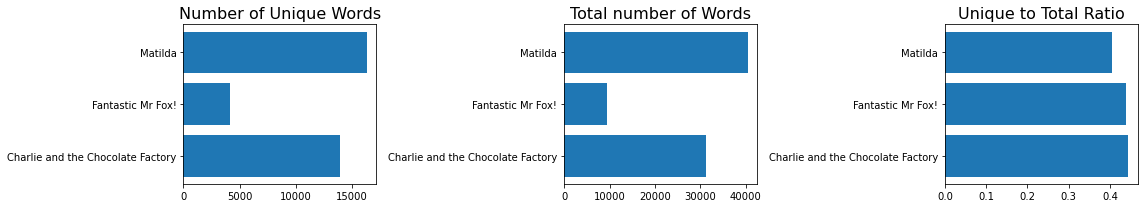

In [28]:
import numpy as np

fig= plt.figure(figsize=(16,3)) 

y_pos = np.arange(len(unique_total_dtm))

# Plot for unique words
plt.subplot(1, 3, 1) # the 3 digits are n rows, n cols and index in order. (1 row with 2 columns below)
plt.barh(y_pos, unique_total_dtm.unique_count) # horizontal bar plots (< y, width, height, left (nx coordinates on left of bars)=None,*, align='center' >)
plt.yticks(y_pos, unique_total_dtm.full_names)
plt.title('Number of Unique Words', fontsize=16)

# Plot for total number of words
plt.subplot(1, 3, 2) # the 3 digits are n rows, n cols and index in order. (1 row with 2 columns below)
plt.barh(y_pos, unique_total_dtm.total_count, align='center') # horizontal bar plots (< y, width, height, left (nx coordinates on left of bars)=None,*, align='center' >)
plt.yticks(y_pos, unique_total_dtm.full_names)
plt.title('Total number of Words', fontsize=16)

# Plot unique to total ratio
plt.subplot(1, 3, 3) # the 3 digits are n rows, n cols and index in order. (1 row with 2 columns below)
plt.barh(y_pos, unique_total_dtm.utc_ratio, align='center') # horizontal bar plots (< y, width, height, left (nx coordinates on left of bars)=None,*, align='center' >)
plt.yticks(y_pos, unique_total_dtm.full_names)
plt.title('Unique to Total Ratio', fontsize=16)

# Display plot
plt.tight_layout()
plt.show()

## Brief findings for unique/total word count and ratio

As a whole, the unique-to-total word count ratio is more or less 40% across all texts. Nothing too interesting here.

# TF-IDF (Term frequency - inverse data frequency)

A single word might mean less in a longer text, but at the same time common words may contribute less to meaning than more rare ones - this is the issue that TF-IDF aims to tackle. This is a very important technique adopted for analysing similarity across a large number of documents. Once again, the details are as follows:

- Term frequency (tf): frequency of word ( in each document) in the corpus. Ratio of term frequency to total word count.  
  $tf_{i,j} = \frac{n_{i,j}}{\sum_{k} n_{i,j}}$
- Inverse Data Frequency (idf):  used to calculate the weight of rare words across (all documents in) the corpus. Words that rarely occur in the corpus have a high IDF score.  
$idf(w) = log(\frac{N}{df_t})$
- TF-IDF is the product of tf and idf:  
$w_{i,j} = tf_{i,j} \times idf(w)$

- Notation
  - $tf_{i,j}$ = number of occurences of i in j
  - $df_i$ = number of documents containing i
  - N = total number of documents

## Summary
- Term frequency - taking into account how often a term shows up; the more it shows up, the higher the TF-score.
- Inverse term frequency - the more often a term shows up across all documents, the less important it is in our matrix.
- TF-IDF - a product of TF and IDF.

Fortunately, the `TfidfVectorizer` in scikit-learn performs all of this for us. We start with `basic_cleaned_corpus.pkl`.

## Parameters